In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display_html, display, Math, HTML

# Estimating Counts

```{margin}
These sections continue to draw extensively on [Think Bayes](https://greenteapress.com/wp/think-bayes) by Allen B. Downey.
```

In the last lecture we solved problems that involve estimating proportions. 

In particular, in the Euro problem, we estimated the probability that a coin lands heads up.

In this lecture, we’ll work on problems related to counting, or estimating the size of a population.

## The Train Problem

The Train Problem comes from
in Frederick Mosteller's, [*Fifty Challenging Problems in
  Probability with Solutions*](https://store.doverpublications.com/0486653552.html):

> "A railroad numbers its locomotives in order $1 \dots N.$  One day you see a locomotive with the number 60.  Estimate how many locomotives the railroad has."

```{margin}
Photo credits: [DALL-E.](https://openai.com/product/dall-e-2) Prompts: "Person watching a train go by with the number 60 on its front"
```

<center>
    
<img src="images/DALLE-person-watching-a-train-go-by-with-the-number-60-on-its-front.png" width="350px">
    
</center>

Based on this observation, we know the railroad has 60 or more
locomotives.  But how many more?  

To apply Bayesian reasoning, we
can break this problem into two steps:

* What did we know about $N$ before we saw the data?

* For any given value of $N$, what is the likelihood of seeing the data (a locomotive with number 60)?

The answer to the first question is the prior.  

The answer to the
second question is the likelihood.

We don't have much basis to choose a prior, so we'll start with
something simple and then consider alternatives.

Let's assume that $N$ is equally likely to be any value from 1 to 1000.

Here's the prior distribution:

In [2]:
from scipy.stats import randint
max_N = 1000

N_dist = pd.DataFrame(index = np.arange(1, max_N + 1))

# using a uniform prior distribution
N_dist['probs'] = randint(1, max_N + 1).pmf(np.arange(1, max_N + 1)) 

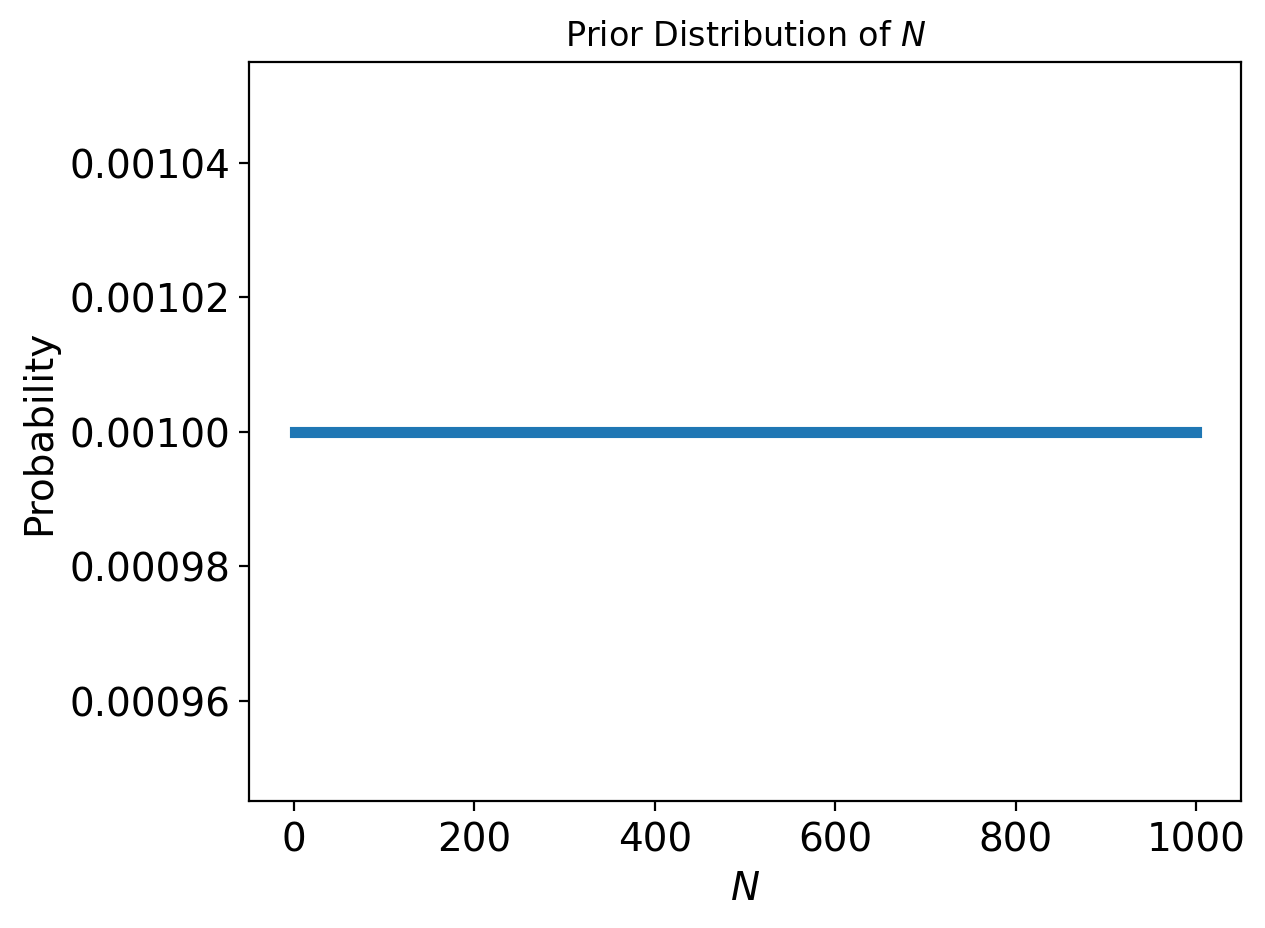

In [3]:
N_dist.plot(lw = 4, legend = False, title = 'Prior Distribution of $N$', fontsize = 14)
plt.xlabel('$N$', size = 14)
plt.ylabel('Probability', size = 14);

Now let's figure out the likelihood of the data.

In a hypothetical fleet of $N$ locomotives, what is the probability that we would see number 60?

If we assume that we are equally likely to see any locomotive, the chance of seeing any particular one is $1/N$.

However, for values of $N < 60$, the data are impossible -- meaning their likelihood is zero.

In [4]:
def likelihood(max_N, data):
    '''Returns the likelihood of seeing a particular locomotive number (data)
       when the company has max_n locomotives in all'''
    lval = pd.DataFrame(index = np.arange(1, max_N + 1))
    lval['likelihoods'] = 1 / np.arange(1, max_N + 1)
    lval['likelihoods'][lval.index < data] = 0
    return lval['likelihoods']

In [5]:
def update(distribution, likelihood):
    '''our standard Bayesian update function'''
    distribution['probs'] = distribution['probs'] * likelihood
    prob_data = distribution['probs'].sum()
    distribution['probs'] = distribution['probs'] / prob_data
    return distribution

Now let's perform a Bayesian update using the observed data "60":

In [6]:
update(N_dist, likelihood(1000, 60));

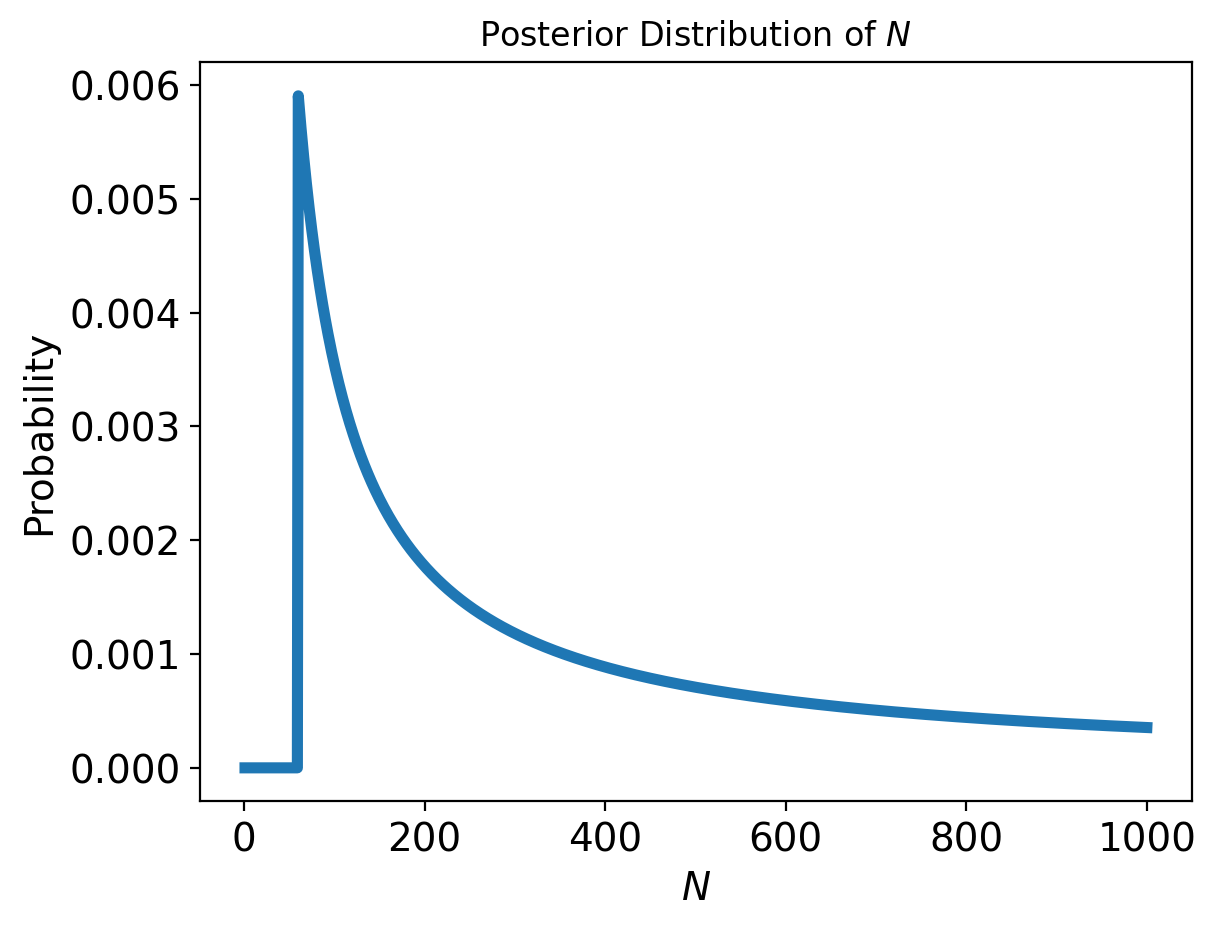

In [7]:
N_dist.plot(lw = 4, legend = False, title = 'Posterior Distribution of $N$', fontsize = 14)
plt.xlabel('$N$', size = 14)
plt.ylabel('Probability', size = 14);

Not surprisingly, all values of $N$ below 60 have been eliminated.

The most likely value, if you had to guess, is 60.

In [8]:
N_dist['probs'].idxmax()

60

Now, if you want to maximize your chances of getting
the answer __exactly right,__ you should guess that the train company has 60 trains.

That is the MAP estimate of $N$.

## Minimum Mean Squared Error (MMSE)

On the other hand, you'd probably be happy to get an answer that is __close__ to the right answer -- and for that, the MAP estimate is not always best.

In this case, the posterior distribution is highly skewed, and the MAP estimate (60) is actually very close to some _impossible_ values (59, 58, ... etc).

Previously, we used the [__Mean Squared Error__](13-Parameter-Estimation.html#Mean-Squared-Error) to judge the quality of an estimator. 

$$ \operatorname{MSE}(\hat{\theta}) = E[(\hat{\theta} - \theta)^2] $$

This metric measures the "average distance squared" between the estimator and the true value. In the frequentist perspective on statistics, $\theta$ is fixed but unknown, while the point estimate $\hat{\theta}$ is a function of the data (and therefore is a random variable).

In a Bayesian setting, the __Minimum Mean Squared Error__ estimator specifically means that $\hat{\theta}$ is fixed but unkown, and the expectation is over the posterior distribution of the parameter $\theta$, which we just calculated.

Let's find the MMSE.

$$ E[(\hat{\theta} - \theta)^2] = \sum_\theta p(\theta) \,(\hat{\theta} - \theta)^2 $$

To find the $\hat{\theta}$ that minimizes MMSE, we take the derivative of MMSE with respect to $\hat{\theta}$:

$$ \frac{d}{d\hat{\theta}} \sum_\theta p(\theta) \,(\hat{\theta} - \theta)^2 = 2 \sum_\theta p(\theta) (\hat{\theta} - \theta) $$

And we set it to zero:

$$ 2 \sum_\theta p(\theta) (\hat{\theta} - \theta) = 0 $$

$$ 2 \hat{\theta} \sum_\theta p(\theta)  = 2 \sum_\theta p(\theta) \theta $$

Now, $\sum_\theta p(\theta) = 1$, and $\sum_\theta p(\theta) \theta = E[\theta]$, so:

$$ \hat{\theta} = E[\theta] $$

This is a very useful result!   

The MMSE estimator of a parameter is equal to the __mean__ of its posterior!

So we can easily compute the MMSE estimate of $N$ for our problem:

$$ \text{MMSE}(N) = E[N] = \sum_{n=1}^{1000} n \cdot p(n) $$

In [9]:
np.sum(N_dist.index * N_dist['probs'])

333.4198932637079

The mean of the posterior is 333, so that might be a good guess if you want to minimize error.

## Sensitivity to the Prior

The prior used in the previous section is uniform from 1 to 1000, but we offered no justification for choosing a uniform distribution or that particular upper bound.

We might wonder whether the posterior distribution is sensitive to the prior.

With so little data---only __one__ observation---it absolutely __is__ sensitive to the prior.

This table shows what happens as we vary the upper bound:

In [10]:
import pandas as pd

df = pd.DataFrame(columns=['Posterior mean'])
df.index.name = 'Upper bound'

for max_N in [500, 1000, 2000]:
    N_dist = pd.DataFrame(index = np.arange(1, max_N + 1))

    # using a uniform prior distribution
    N_dist['probs'] = randint(1, max_N + 1).pmf(np.arange(1, max_N + 1)) 
    
    update(N_dist, likelihood(max_N, 60))

    df.loc[max_N] = np.sum(N_dist.index * N_dist['probs'])
    
df

,Posterior mean
Upper bound,
500,207.079228
1000,333.419893
2000,552.179017


As we vary the upper bound, the posterior mean changes substantially.
So that's bad.  

When the posterior is sensitive to the prior, there are two ways to proceed:

* Get more data.

* Get more background information and choose a better prior.

With more data, posterior distributions based on different priors tend to converge.  
For example, suppose that in addition to train 60 we also see trains 30 and 90.

Here's how the posterior means depend on the upper bound of the prior, when we observe three trains:

In [11]:
df = pd.DataFrame(columns=['Posterior mean'])
df.index.name = 'Upper bound'

dataset = [30, 60, 90]

for max_N in [500, 1000, 2000]:
    N_dist = pd.DataFrame(index = np.arange(1, max_N + 1))

    # using a uniform prior distribution
    N_dist['probs'] = randint(1, max_N + 1).pmf(np.arange(1, max_N + 1)) 
    
    for data in dataset:
        update(N_dist, likelihood(max_N, data))

    df.loc[max_N] = np.sum(N_dist.index * N_dist['probs'])
    
df

,Posterior mean
Upper bound,
500,151.849588
1000,164.305586
2000,171.338181


With just three observations, the differences become much smaller.

However, three observations is not yet enough for the posteriors to converge.

## Empirical Bayes

Another option for improving our estimate is to improve the
priors by gathering more background information.

It is probably not reasonable to assume that a train-operating company with 1000 locomotives is just as likely as a company with only 1.

With some effort, we could probably find a list of companies that
operate locomotives in the area of observation.
Or we could interview an expert in rail shipping to gather information about the typical size of companies.

The general idea of using data to estimate the prior distribution is called __Empirical Bayes.__

But even without getting into the specifics of railroad economics, we
can make some educated guesses.

In most fields, there are many small companies, fewer medium-sized companies, and only one or two very large companies.

```{margin}
Many aspects of human society follow power-laws, including income distributions and city sizes.  The fact that company sizes follow power-laws is discussed by
Robert Axtell in [Science](<http://www.sciencemag.org/content/293/5536/1818.full.pdf>).
```

In fact, the distribution of company sizes tends to follow a _power law._

This law suggests that if there are 1000 companies with fewer than
10 locomotives, there might be 100 companies with 100 locomotives,
10 companies with 1000, and possibly one company with 10,000 locomotives.

Mathematically, a power law means that the number of companies with a given size, $N$, is proportional to $(1/N)^{\alpha}$, where $\alpha$ is a parameter that is often near 1.

We can construct a power law prior like this:

In [12]:
max_N = 1000
alpha = 1.0

power = pd.DataFrame(index = np.arange(1, max_N + 1))
power['probs'] = power.index ** (-alpha)
power['probs'] = power['probs'] / power['probs'].sum()

And for comparison we'll use the uniform prior again:

In [13]:
unif = pd.DataFrame(index = np.arange(1, max_N + 1))
unif['probs'] = randint(1, max_N + 1).pmf(np.arange(1, max_N + 1)) 

Here's what a power law prior looks like, compared to the uniform prior:

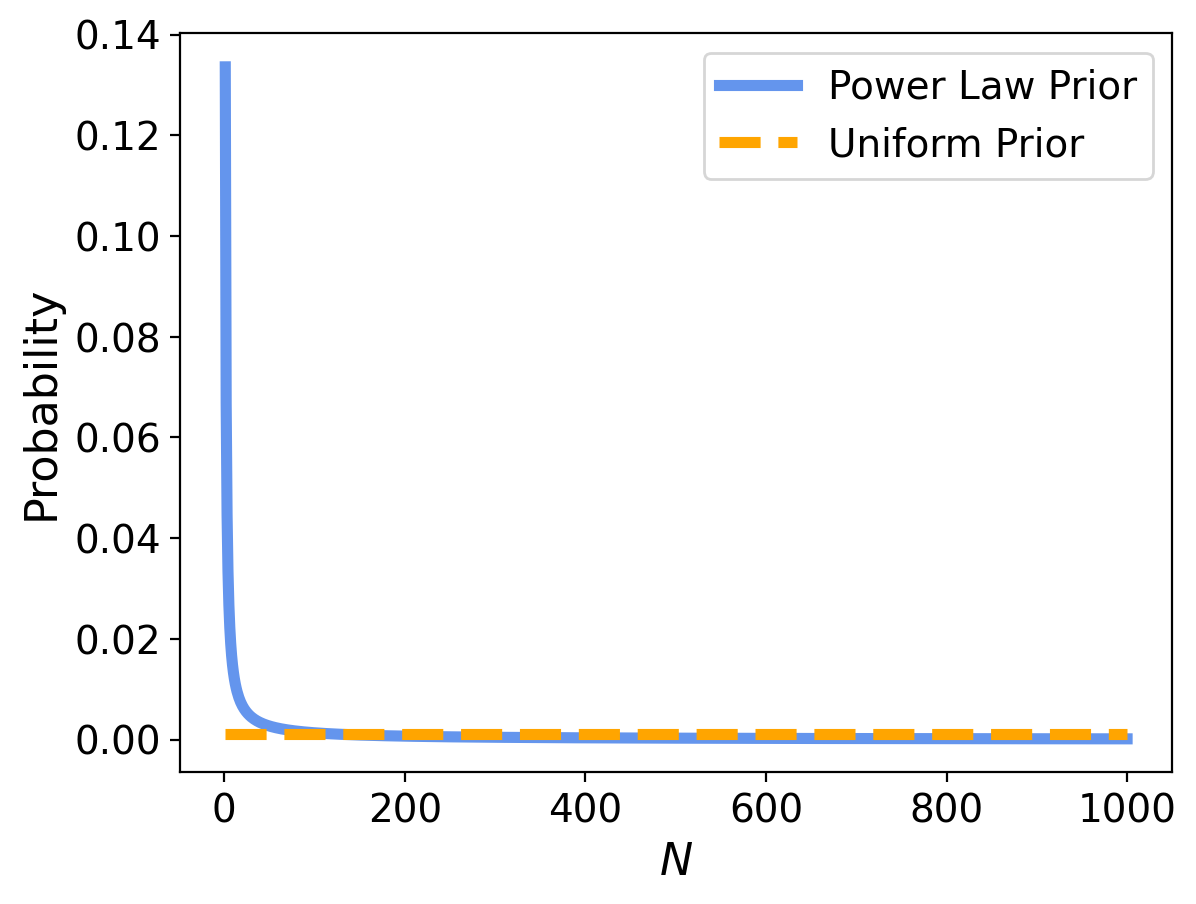

In [14]:
fig, ax = plt.subplots()
power.plot(ax = ax, color = 'cornflowerblue', lw = 4, fontsize = 14)  
unif.plot(ax = ax, color = 'orange', lw = 4, style = '--', fontsize = 14)
ax.legend(['Power Law Prior', 'Uniform Prior'], fontsize = 14, loc = 'best')
plt.xlabel('$N$', size = 16)
plt.ylabel('Probability', size = 16);   

This can be easier to see on a log-log plot:

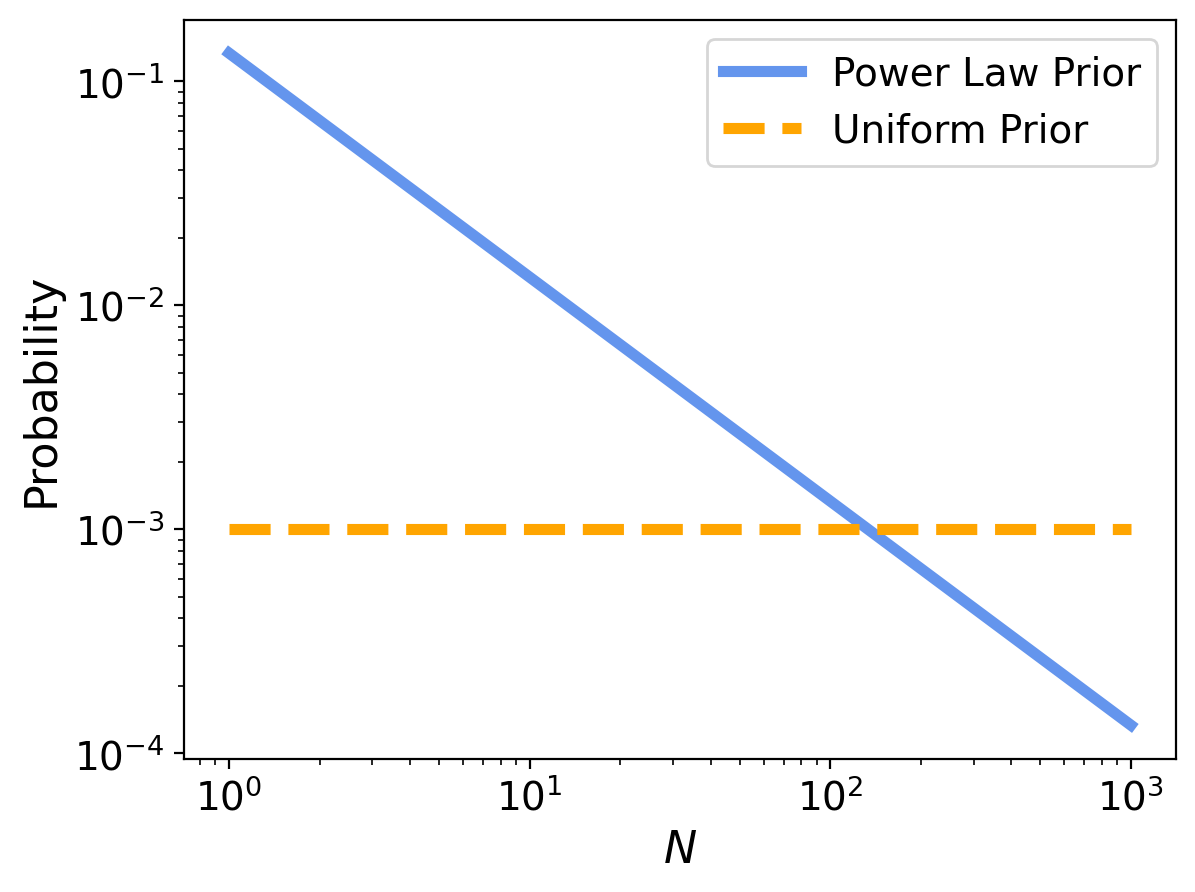

In [15]:
fig, ax = plt.subplots()
power.plot(ax = ax, logy=True, logx=True, color = 'cornflowerblue', lw = 4, fontsize = 14)  
unif.plot(ax = ax, color = 'orange', lw = 4, style = '--', fontsize = 14)
ax.legend(['Power Law Prior', 'Uniform Prior'], fontsize = 14, loc = 'best')
plt.xlabel('$N$', size = 16)
plt.ylabel('Probability', size = 16);   

For each prior we will perform a __Bayesian update__ by multiplying the priors by the likelihoods, then normalizing:

$$ P(N\,\vert\,D) = \frac{ P(N) \cdot P(D\,\vert\,N)}{P(D)}. $$

That is:

$$ \text{Posteriors} = \frac{ \text{Priors} \cdot \text{Likelihoods}}{\text{Normalizer}} $$


In [16]:
update(power, likelihood(1000, 60));
update(unif, likelihood(1000, 60));

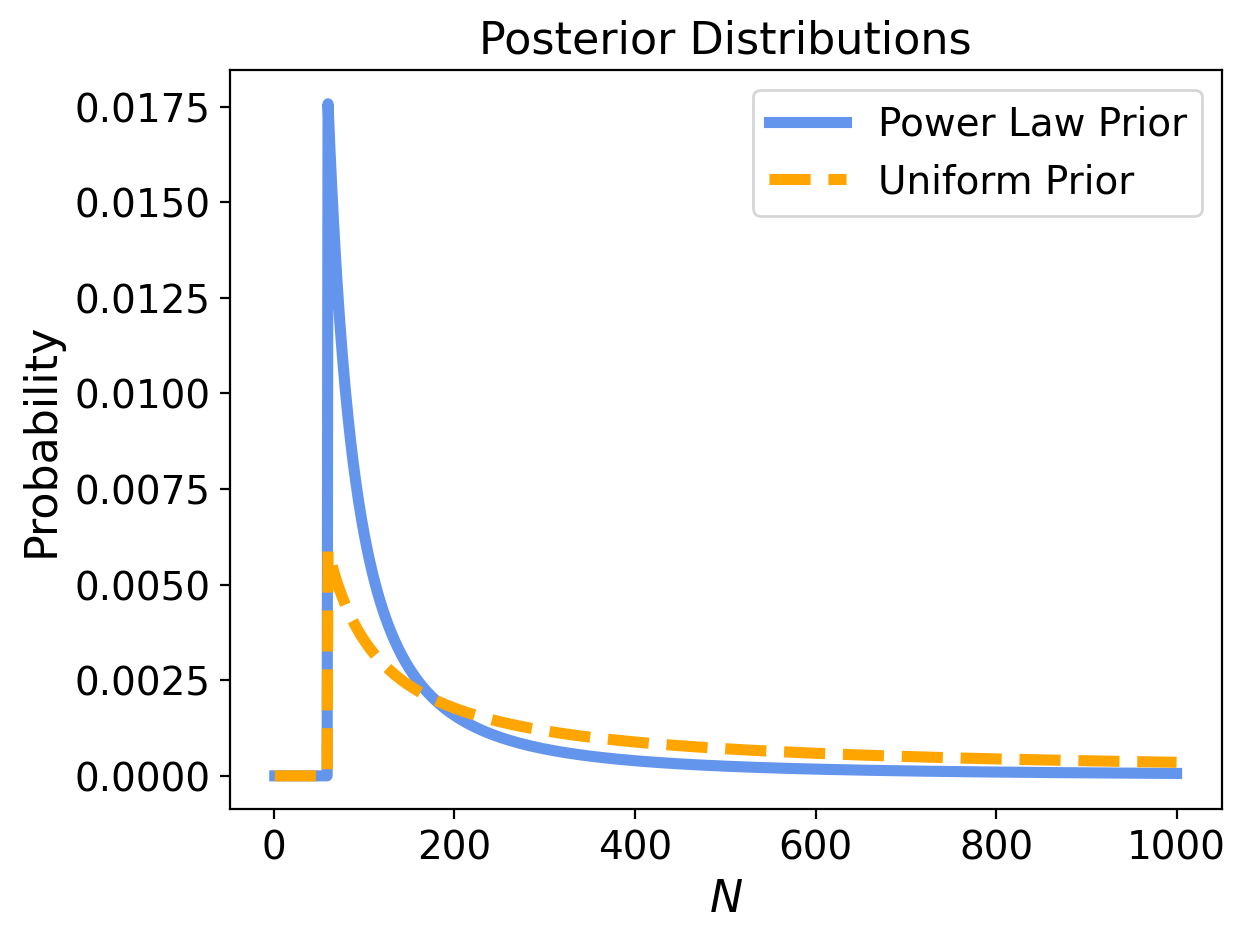

In [17]:
fig, ax = plt.subplots()
power.plot(ax = ax, color = 'cornflowerblue', lw = 4, fontsize = 14)  
unif.plot(ax = ax, color = 'orange', lw = 4, style = '--', fontsize = 14)
ax.legend(['Power Law Prior', 'Uniform Prior'], fontsize = 14, loc = 'best')
plt.xlabel('$N$', size = 16)
plt.ylabel('Probability', size = 16)
plt.title('Posterior Distributions', size = 16);   

The power law gives less prior probability to high values, which yields lower posterior means, and less sensitivity to the upper bound.

Here's how the posterior means depend on the upper bound when we use a power law prior and observe three trains:

In [18]:
df = pd.DataFrame(columns=['Posterior mean'])
df.index.name = 'Upper bound'

dataset = [30, 60, 90]

for max_N in [500, 1000, 2000]:
    
    # using a power law prior
    power = pd.DataFrame(index = np.arange(1, max_N + 1))
    power['probs'] = power.index ** (-alpha)
    power['probs'] = power['probs'] / power['probs'].sum()
    
    for data in dataset:
        update(power, likelihood(max_N, data))

    df.loc[max_N] = np.sum(power.index * power['probs'])
    
df

,Posterior mean
Upper bound,
500,130.708470
1000,133.275231
2000,133.997463


Now the differences are much smaller.  In fact,
with an arbitrarily large upper bound, the mean converges on 134.

So the power law prior 
* is more realistic, because it is based on
general information about the size of companies ("Empirical Bayes")
* and it behaves better in practice.

## Credible Intervals

So far we have seen two ways to summarize a posterior distribution: the value with the highest posterior probability (the MAP) and the posterior mean (the MMSE).
These are both **point estimates**, that is, single values that estimate the quantity we are interested in.

In general, whenever we have a point estimate, we'd like to know how concentrated likely values are around that estimate.

For example, in the frequentist approach, we want to see confidence intervals around a point estimate, so we can see how representative the point estimate really is.

In the Bayesian case, this is particularly simple to do (because we have the entire distribution of values of the parameter!)

What we will do is look for an interval that contains "most" of the posterior probability distribution.

This is called a __credible interval.__

```{margin}
Of course it's always possible to choose a very small $a$ and a very large $b$, so that the probability captured between them is sure to be 0.9 or more.  But that's not as useful as finding a small credible interval $(a, b)$. To be most useful, we would like $a$ and $b$ to be as close together as possible. So for a 90% credible interval, we'll specifically look for the largest $a$ such that $P[(N\,\vert\,D) \leq a] \leq 0.05$, and the smallest $b$ such that $P[(N\,\vert\,D) > b] \leq 0.05$.  We'll call this "the" credible interval (even though there could be others).
```

For example, let's look for an interval in which we are 90\% confident that the parameter lies.

So we are looking for bounds $a$ and $b$ such that $P[a < (H\,\vert\,D) \leq b] \ge 0.9$.

A simple way to visualize this is to consider the CDF of the posterior.

In [19]:
max_N = 1000
power = pd.DataFrame(index = np.arange(1, max_N + 1))
power['probs'] = power.index ** (-alpha)
power['probs'] = power['probs'] / power['probs'].sum()
update(power, likelihood(1000, 60));

Here is the posterior for the power-law prior with upper bound 1000, after the single train observation of 60:

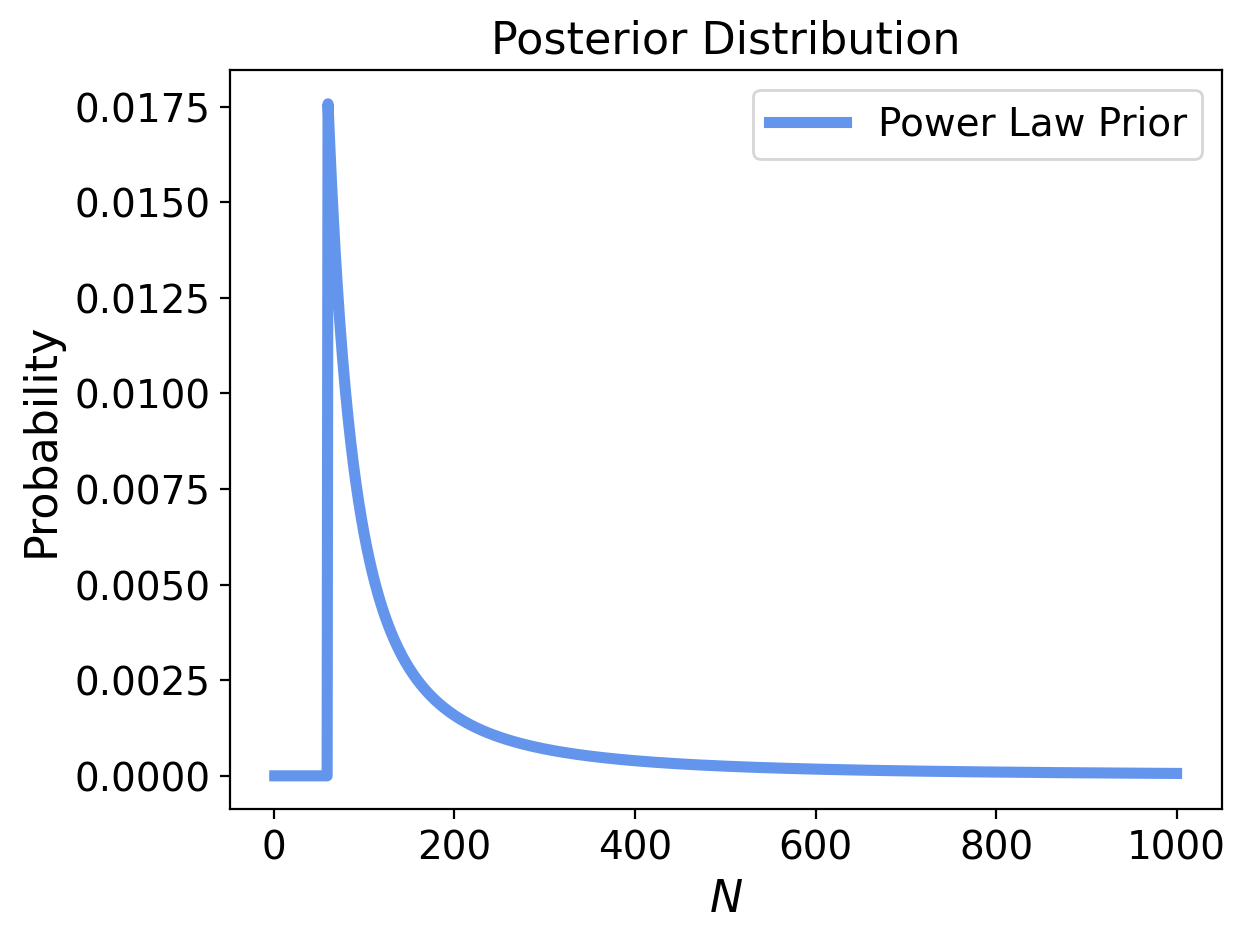

In [20]:
fig, ax = plt.subplots()
power.plot(ax = ax, color = 'cornflowerblue', lw = 4, fontsize = 14)  
ax.legend(['Power Law Prior'], fontsize = 14, loc = 'best')
plt.xlabel('$N$', size = 16)
plt.ylabel('Probability', size = 16)
plt.title('Posterior Distribution', size = 16);   

And we can easily calculate its CDF:

In [21]:
power['cdf'] = np.cumsum(power['probs'])

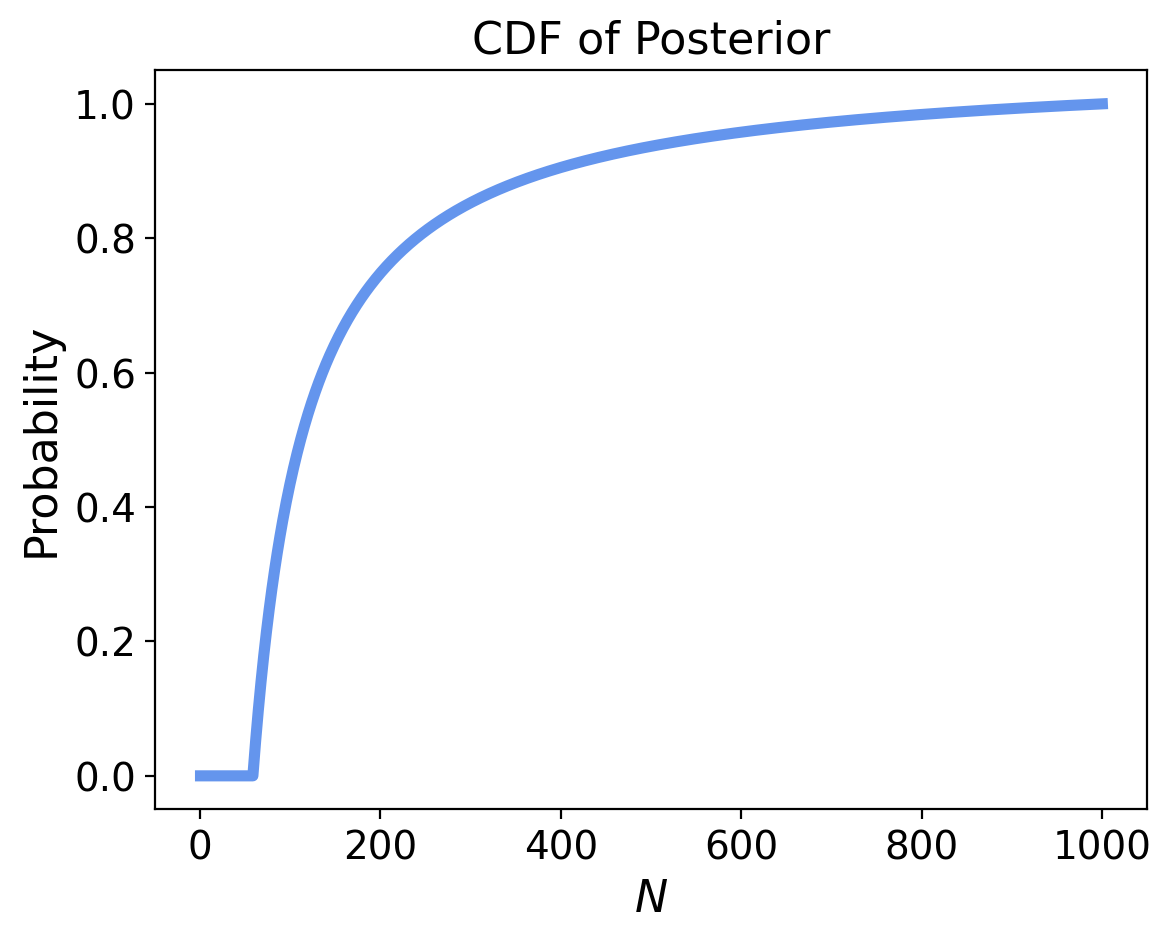

In [22]:
fig, ax = plt.subplots()
power['cdf'].plot(ax = ax, color = 'cornflowerblue', lw = 4, fontsize = 14)  
plt.xlabel('$N$', size = 16)
plt.ylabel('Probability', size = 16)
plt.title('CDF of Posterior', size = 16); 

Let's set $a$ so that $P[(N\,\vert\,D) \leq a] = 0.05$, and set $b$ so that $P[(N\,\vert\,D) > b] = 0.05$

In [23]:
# find a such that P[N|D <= a] is <= 0.05
a = max(power.index[power['cdf'] <= .05])
a

61

In [32]:
# find b such that P[N|D > b] is > 0.95
b = min(power.index[power['cdf'] > .95])
b

559

In [33]:
# confirm that this is a 90% credible interval
power['cdf'].iloc[b] - power['cdf'].iloc[a]

0.8993289984346797

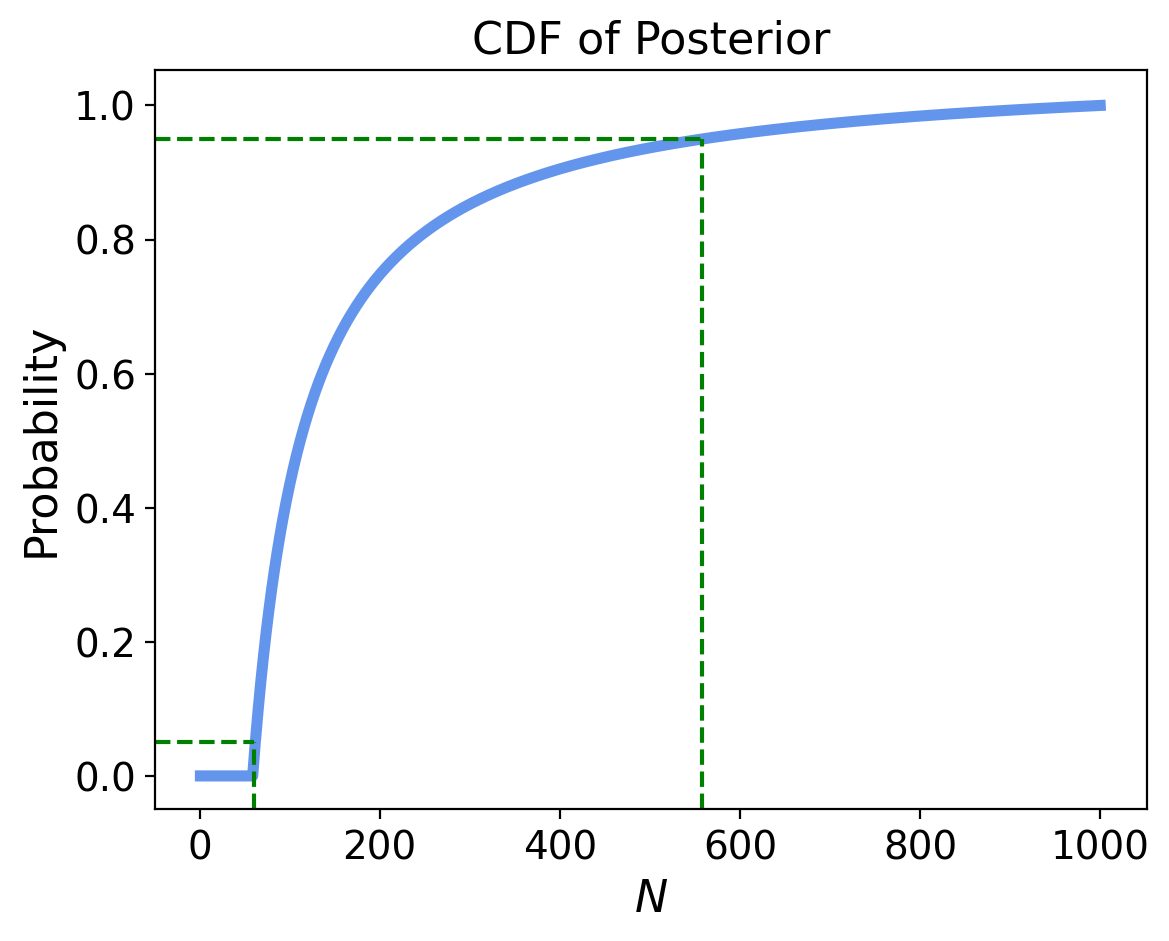

In [27]:
fig, ax = plt.subplots()
power['cdf'].plot(ax = ax, color = 'cornflowerblue', lw = 4, fontsize = 14)
ymin = power['probs'].min()
# ax.set_ylim(ymin = ymin)
# plt.plot(a, power['cdf'].iloc[a], 'o', color = 'orange', markersize = 10)
ymin, ymax = plt.ylim()
xmin, xmax = plt.xlim()
plt.vlines(a, ymin = ymin, ymax = power['cdf'].iloc[a], linestyles = 'dashed', color = 'g')
#plt.plot(a, ymin, 'o', color = 'g', markersize = 14, clip_on = False)
#plt.plot(b, power['cdf'].iloc[b], 'o', color = 'orange', markersize = 10)
plt.vlines(b, ymin = ymin, ymax = power['cdf'].iloc[b], linestyles = 'dashed', color = 'g')
plt.hlines(power['cdf'].iloc[a], xmin = xmin, xmax = a, linestyles = 'dashed', color = 'g')
plt.hlines(power['cdf'].iloc[b], xmin = xmin, xmax = b, linestyles = 'dashed', color = 'g')
#plt.plot(b, ymin, 'o', color = 'g', markersize = 14, clip_on = False)
ax.set_ylim(ymin = ymin)
ax.set_xlim(xmin = xmin)
plt.xlabel('$N$', size = 16)
plt.ylabel('Probability', size = 16)
plt.title('CDF of Posterior', size = 16); 

So we find that the 90\% credible interval for $p$ is (61, 558).

We could then report our estimate of $N$ as:
* MMSE = 133
* 90% Credible Interval = (61, 558)

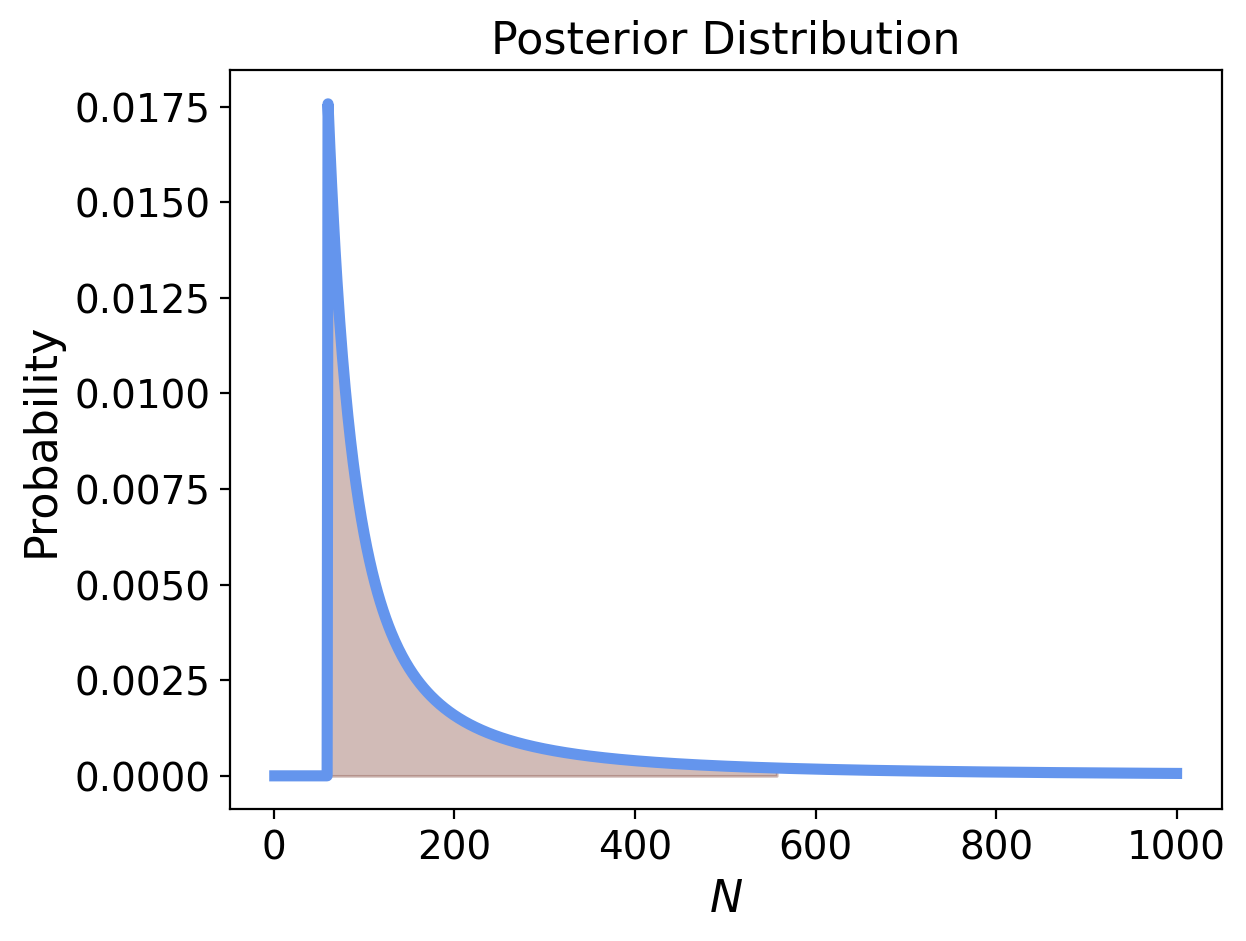

In [28]:
fig, ax = plt.subplots()
power['probs'].plot(ax = ax, color = 'cornflowerblue', lw = 4, fontsize = 14)  
plt.xlabel('$N$', size = 16)
plt.ylabel('Probability', size = 16)
plt.fill_between(np.arange(a, b), power['probs'].iloc[range(a, b)], 0, color='C5', alpha=0.4)
plt.title('Posterior Distribution', size = 16);   

## More on Priors

Among Bayesians, there are two approaches to choosing prior
distributions.  

1. Some recommend choosing the prior that best represents
background information about the problem; in that case the prior
is said to be **informative**.  The problem with using an informative
prior is that people might have different information or
interpret it differently.  So informative priors might seem arbitrary.

2. The alternative is a so-called **uninformative prior**, which is
intended to be as unrestricted as possible, in order to let the data
speak for itself.  In some cases you can identify a unique prior
that has some desirable property, like representing minimal prior
information about the estimated quantity.

Uninformative priors are appealing because they seem more
objective.  

But do not hesitate to use informative priors.

Why?  First, Bayesian analysis is always based on
modeling decisions.  

Choosing the prior is one of those decisions, but
it is not the only one, and it might not even be the most subjective.
So even if an uninformative prior is more objective, the entire analysis is still subjective.

Also, for most practical problems, you are likely to be in one of two
situations: either you have a lot of data or not very much.  
* If you have a lot of data, the choice of the prior doesn't matter;
informative and uninformative priors yield almost the same results.
* If you don't have much data, using relevant background information (like the power law distribution) makes a big difference.

## Frequentist vs Bayes

We are now in a position to more fully characterize the two approaches to statistics:

<center>

<img src="images/Bayes-Frequentism.png" width="500px">

</center>

We can summarize the differences as follows:

__Probability:__
* Frequentist probability assumes that data represents "independent trials under identical conditions." 
* Bayesian probability uses probability to model our __degree of belief__ (also called __credence__) of a hypothesis.

__Statistical Approach:__
* A typical goal of frequentist statistics is to infer the parameters of the distribution that the data came from.
* A typical goal of Bayesian statistics is to update our degree of belief about the parameters using the data.

__Point Estimates:__
* A typical point estimator used in frequentist statistics is the Maximum Likelihood Estimate (MLE)
* A typical point estimator used in Bayesian statistics is the MAP estimate or the MMSE estimate

__Uncertainty:__
* The uncertainty of a point estimate in frequentist statistics is expressed using a confidence interval
* The uncertainty of a point estimate in Bayesian statistics is expressed using a credible interval

__Slogan:__ In frequentist statistics, the model is fixed and the data are random; in Bayesian statistics the data are fixed and the model is random.